In [1]:
import pickle

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import spatial
from collections import Counter
from torchvision.datasets import Caltech101
from sklearn.model_selection import train_test_split

/home/volta/Documents/ucph/vip/4_assignment/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
caltech101 = Caltech101('./caltech101', download=True)

Files already downloaded and verified


In [3]:
categories = range(0,21)
dataset = []
for i,cls in caltech101:
    if cls in categories:
        dataset.append([i,cls])

In [4]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset, columns=['image', 'category'])

In [5]:
train_dataset, test_dataset = train_test_split(dataset, train_size=.5)
train_df = dataset_to_df(train_dataset)
test_df = dataset_to_df(test_dataset)

In [6]:
train_df

image  category
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...        10
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...         2
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...         1
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...         3
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...         3
...                                                 ...       ...
1842  <PIL.JpegImagePlugin.JpegImageFile image mode=...        15
1843  <PIL.JpegImagePlugin.JpegImageFile image mode=...         0
1844  <PIL.JpegImagePlugin.JpegImageFile image mode=...         3
1845  <PIL.JpegImagePlugin.JpegImageFile image mode=...         0
1846  <PIL.JpegImagePlugin.JpegImageFile image mode=...         3

[1847 rows x 2 columns]

In [7]:
def to_gray(img):
    array = np.array(img)
    gray = cv.cvtColor(array, cv.COLOR_BGR2GRAY)
    return gray

In [8]:
def sift(gray_img):
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc


def imshow_key_points(img):
    gray = to_gray(img_ex)
    kp, _ = sift(gray)
    plt.imshow(cv.drawKeypoints(gray, kp, img))
    plt.show()


def get_the_centroids(vector, centroids):
    tree = spatial.KDTree(centroids)
    dist, idxs = tree.query(vector)
    return idxs


def get_bag_of_words(doc, centroids):
    idxs = get_the_centroids(doc, centroids)
    return Counter(idxs), idxs


def elbow(ks, inertias):
    plt.plot(ks, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Values of k')
    plt.ylabel('Distortion')
    plt.show()


def get_sift_descriptors(dataset):
    descriptors = {}
    key_points = {}
    classes = {}
    for img, cls in dataset:
        array = np.array(img)
        if len(array.shape) == 3:
            gray = to_gray(img)
        else:
            gray = array
        kp, desc = sift(gray)
        key_points[img.filename] = kp
        descriptors[img.filename] = desc
        classes[img.filename] = cls
    return key_points, descriptors, classes

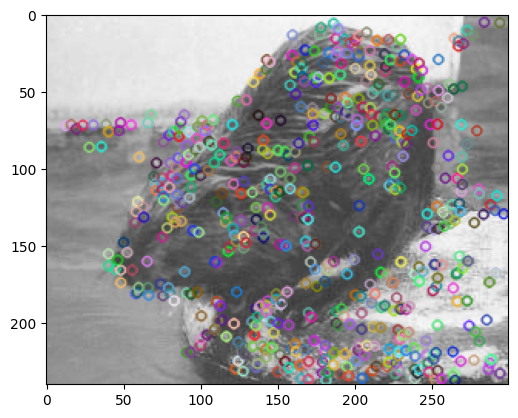

In [9]:
img_ex = train_dataset[0][0]
imshow_key_points(np.array(img_ex))

In [10]:
key_points, descriptors, all_classes = get_sift_descriptors(dataset)
_, train_descriptors, train_classes = get_sift_descriptors(train_dataset)
_, test_descriptors, test_classes = get_sift_descriptors(test_dataset)

In [11]:
def descs_with_cls(descs, cls):
    classes = []
    all_descs = []
    for key in descs:
        img_descs = descs[key]
        classes.append(np.repeat(cls[key],len(img_descs)))
        all_descs.append(img_descs)
        
    return np.concatenate(all_descs), np.concatenate(classes)

In [12]:
X,Y = descs_with_cls(train_descriptors,train_classes)
print(X.shape, Y.shape)

(721859, 128) (721859,)


In [13]:
means_by_class = {}
furthest_vector_dist = {}
for cls in set(Y):
    vectors = X[Y==cls]
    means_by_class[cls] = np.mean(vectors,axis=0)
    # get the most distant vector from the mean
    distances = []
    for vec in vectors:
        distances.append(np.linalg.norm(vec - means_by_class[cls], ord=2))
        
    furthest_vector_dist[cls] = np.max(distances)
    

In [14]:
furthest_vector_dist

{0: 523.5638,
 1: 524.97437,
 2: 479.18295,
 3: 521.92255,
 4: 503.24603,
 5: 550.68317,
 6: 484.16855,
 7: 499.91882,
 8: 512.3919,
 9: 513.2754,
 10: 497.18256,
 11: 499.31665,
 12: 503.5302,
 13: 510.17242,
 14: 516.39996,
 15: 508.28372,
 16: 499.7944,
 17: 515.9952,
 18: 498.5126,
 19: 487.49924,
 20: 504.4472}

In [15]:
def dict_to_vec(dic):
    lst = []
    keys = list(dic.keys())
    keys.sort()
    return np.array([dic[i] for i in keys])

In [16]:
means_by_class

{0: array([26.100105 , 18.753288 , 17.325472 , 18.475275 , 28.498737 ,
        14.19456  , 11.226409 , 13.5081415, 67.83463  , 31.308857 ,
        18.19194  , 17.164274 , 25.094688 , 13.97601  , 13.542725 ,
        25.478182 , 71.7271   , 25.966167 , 14.107075 , 13.29101  ,
        20.370674 , 14.788807 , 17.644688 , 32.780132 , 30.279469 ,
        14.473038 , 11.187228 , 12.010301 , 21.514303 , 16.40227  ,
        17.62356  , 20.304846 , 35.098408 , 19.756277 , 19.05479  ,
        23.525328 , 37.73002  , 19.748882 , 13.015832 , 15.956229 ,
        95.7924   , 33.06755  , 20.028645 , 24.258926 , 35.044304 ,
        18.638042 , 14.744139 , 34.06445  , 99.13832  , 33.287632 ,
        14.660711 , 17.305355 , 29.322554 , 22.388287 , 20.634012 ,
        35.700096 , 40.28088  , 17.232895 , 13.011356 , 17.270885 ,
        29.169998 , 21.03583  , 19.144659 , 21.4239   , 35.18023  ,
        15.94673  , 13.178861 , 19.809866 , 37.74586  , 23.412664 ,
        18.813305 , 19.87701  , 95.8748   , 3

In [17]:
means = dict_to_vec(means_by_class)

In [18]:
dm = spatial.distance_matrix(X,means)
dm

array([[351.96781066, 345.7405118 , 363.33110982, ..., 360.94938479,
        353.34171464, 347.72838272],
       [348.03297653, 342.26830733, 369.62171377, ..., 361.38076534,
        354.91002646, 339.65115348],
       [329.99937718, 323.68139266, 364.76219398, ..., 347.53024749,
        347.06463997, 315.63469668],
       ...,
       [322.79377245, 314.78811288, 351.5975333 , ..., 344.03355639,
        335.11934073, 310.64308049],
       [343.45258364, 335.32858392, 367.42936099, ..., 364.19335343,
        353.39581748, 335.57068865],
       [354.7988274 , 349.34437825, 385.82523532, ..., 372.20231988,
        371.43896414, 342.75930975]])

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_dm = cosine_similarity(X, means)
cosine_dm

array([[0.72805005, 0.73996663, 0.7046117 , ..., 0.7100374 , 0.7257221 ,
        0.73613685],
       [0.7366785 , 0.7475049 , 0.69278306, ..., 0.71004605, 0.7234477 ,
        0.75255764],
       [0.7694147 , 0.78052044, 0.7007907 , ..., 0.7359513 , 0.7372582 ,
        0.7950535 ],
       ...,
       [0.7840812 , 0.79780805, 0.72820294, ..., 0.74425477, 0.7619059 ,
        0.8051641 ],
       [0.74443734, 0.7595544 , 0.696039  , ..., 0.7030473 , 0.7252775 ,
        0.75915235],
       [0.72184086, 0.7323877 , 0.657634  , ..., 0.6861282 , 0.687823  ,
        0.74523133]], dtype=float32)

In [20]:
#dm = cosine_dm

In [21]:
dm.shape

(721859, 21)

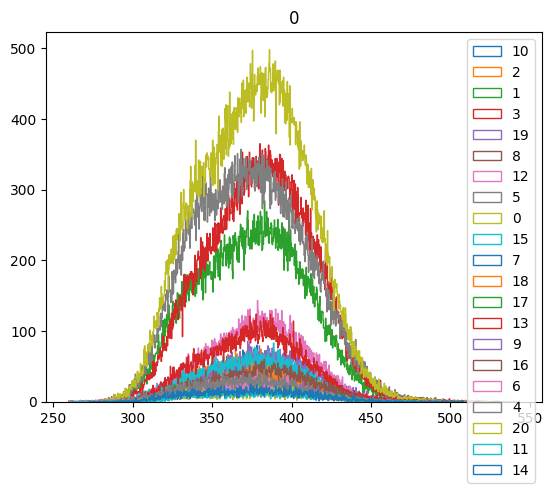

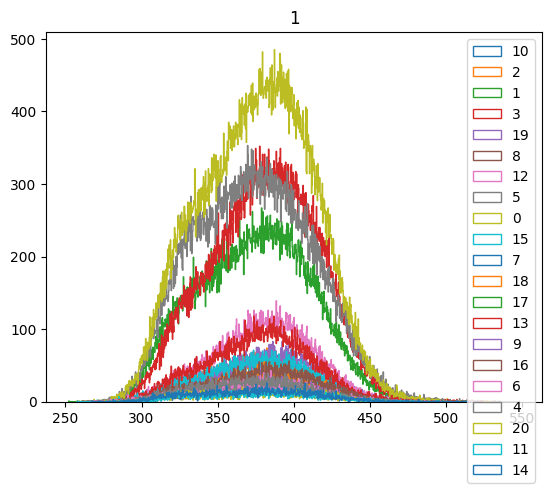

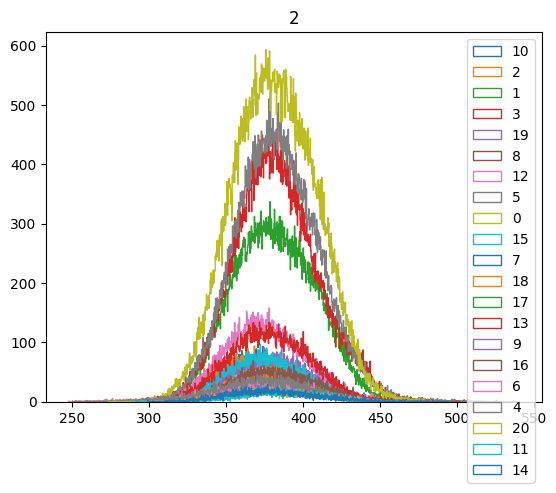

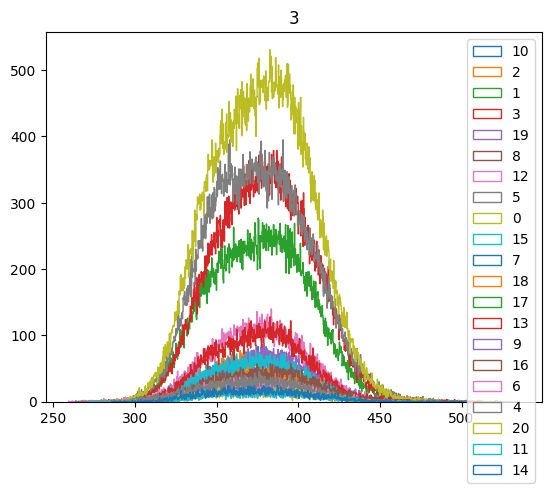

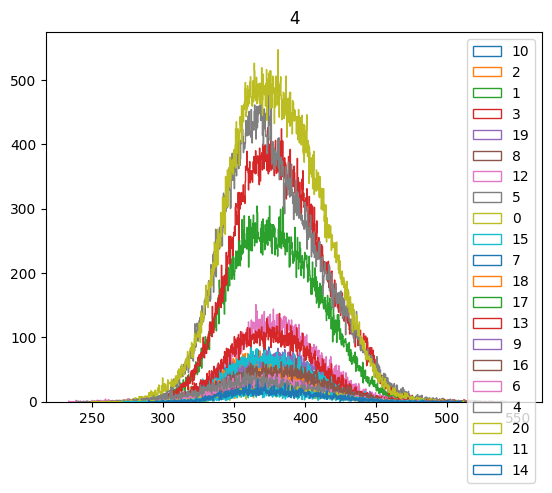

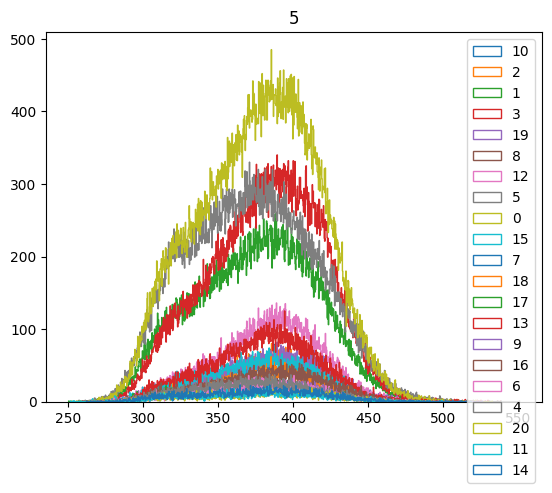

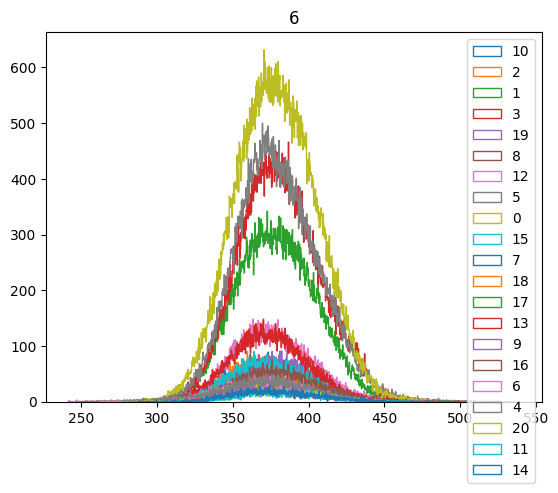

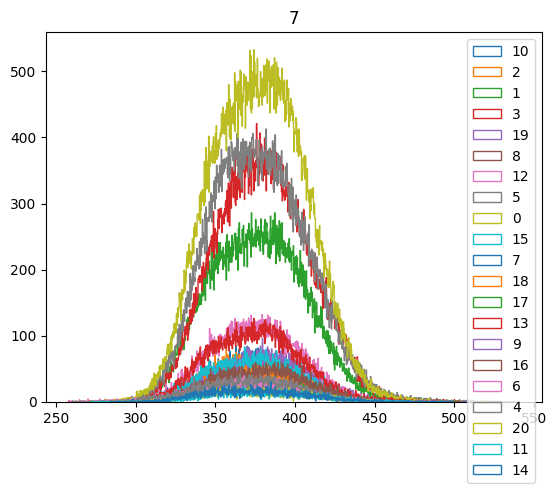

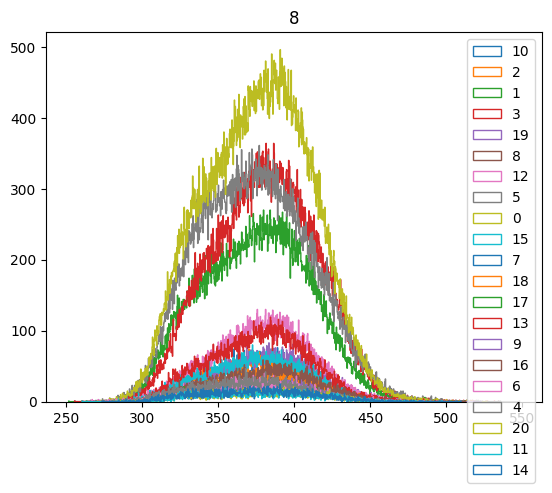

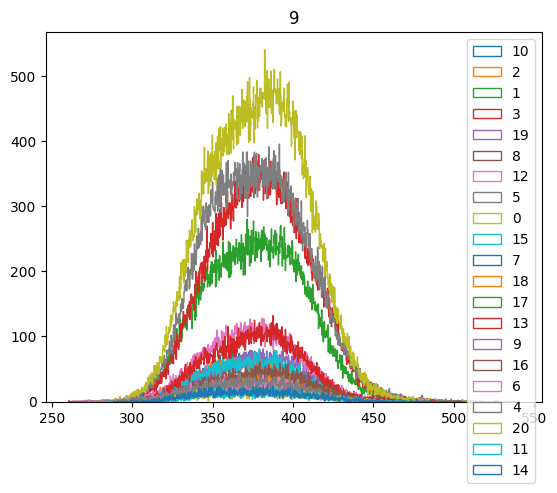

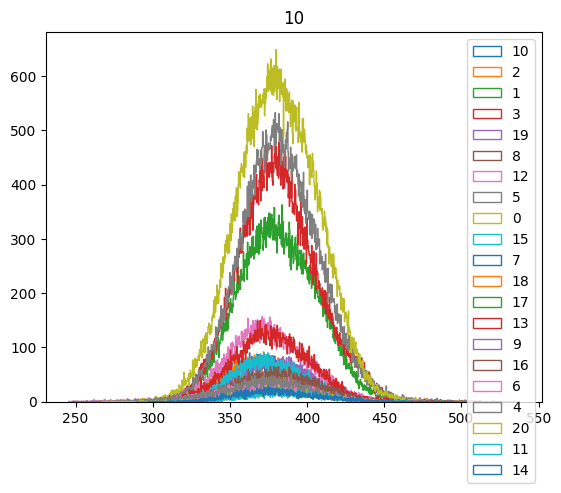

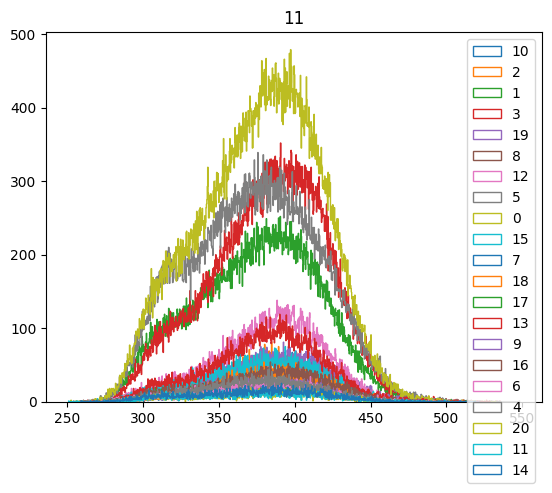

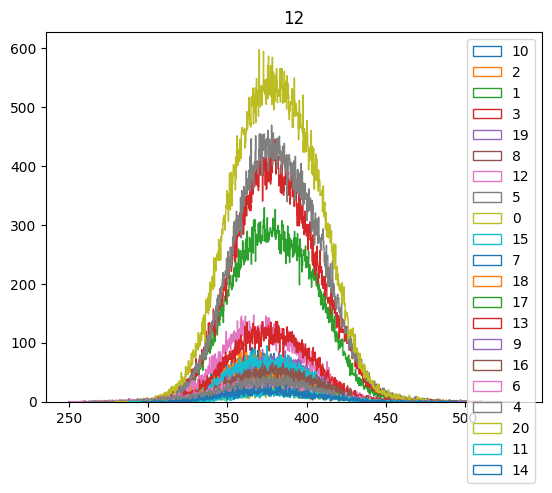

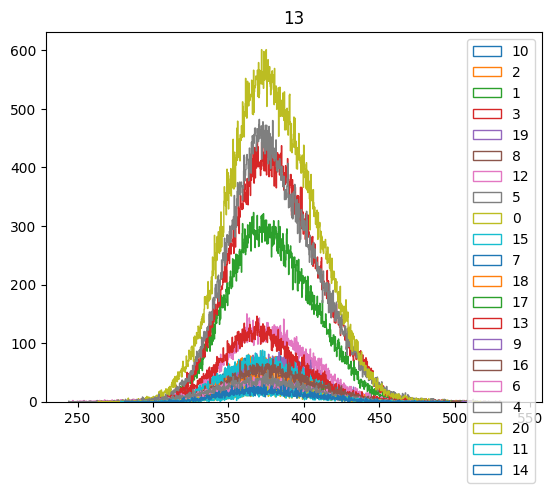

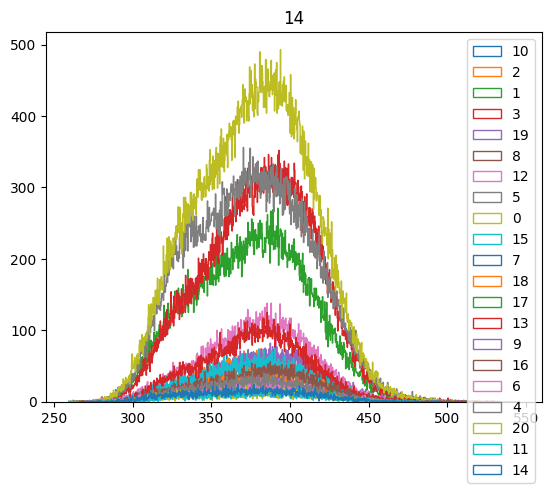

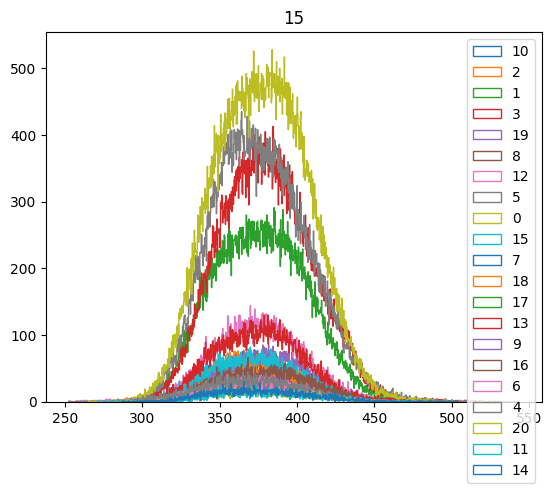

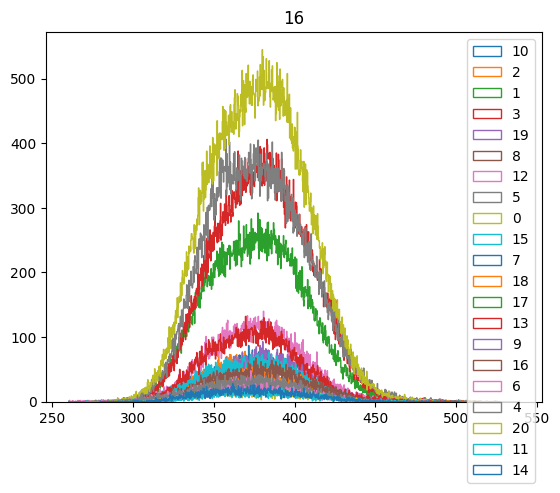

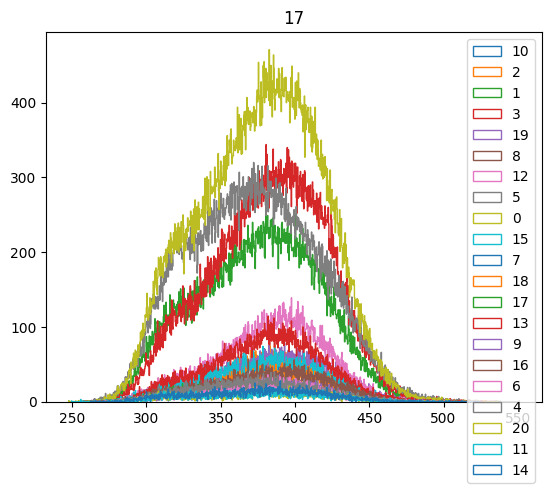

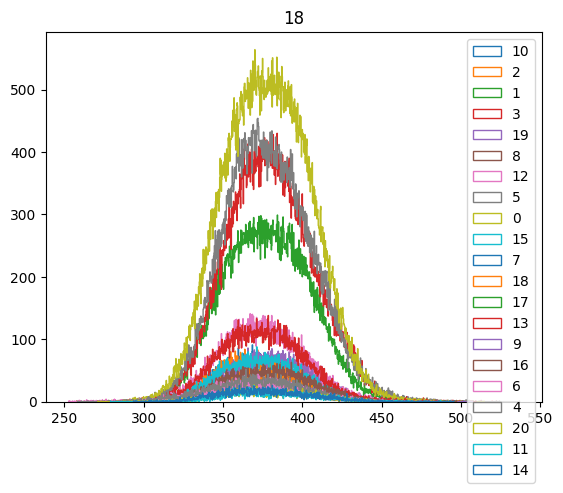

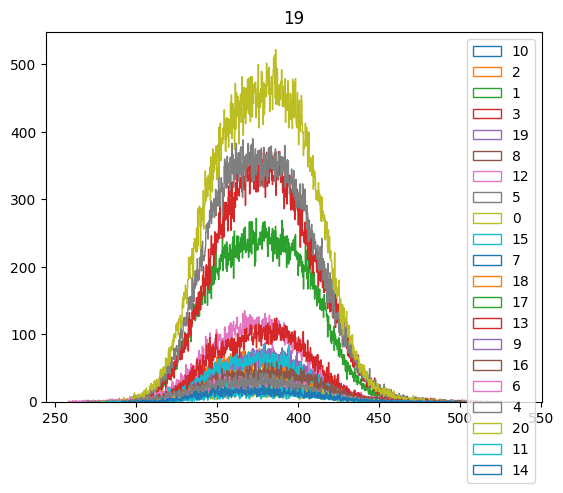

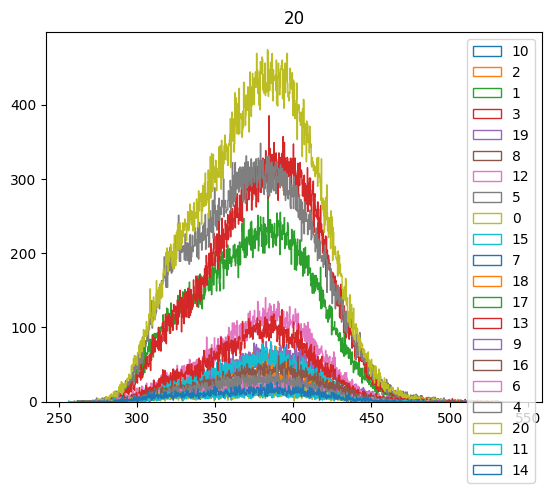

In [22]:
# get the distributions of points 
dm_for_eval = np.transpose(dm)
#fig, axs = plt.subplots(21)
for key in furthest_vector_dist:
    container = {}
    for i, dst in enumerate(dm_for_eval[key]):
        if Y[i] not in container:
            container[Y[i]] = [dst]
        else:
            container[Y[i]].append(dst)
            
    plt.title(str(key))
    for cls in container:
        plt.hist(container[cls], bins=1000, label = str(cls) , histtype='step' )
        plt.legend(loc='upper right')
    plt.show()

In [23]:
Counter(Y)

Counter({10: 19542,
         2: 20852,
         1: 85350,
         3: 109828,
         19: 23856,
         8: 11490,
         12: 36469,
         5: 113325,
         0: 157273,
         15: 21208,
         7: 8034,
         18: 13086,
         17: 9467,
         13: 30943,
         9: 9163,
         16: 15780,
         6: 9561,
         4: 10701,
         20: 4936,
         11: 4816,
         14: 6179})

In [24]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X[:100000])

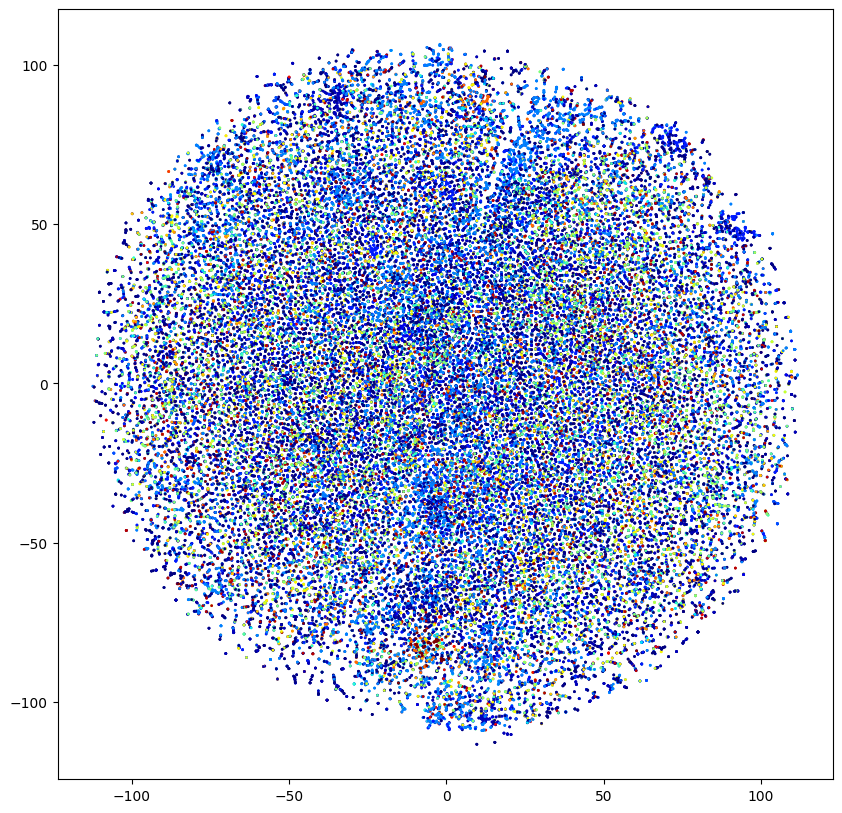

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y[:100000], s=1, cmap=plt.cm.get_cmap("jet", len(set(Y[:100000]))))
plt.show()  

In [26]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(X[:100000])
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled)

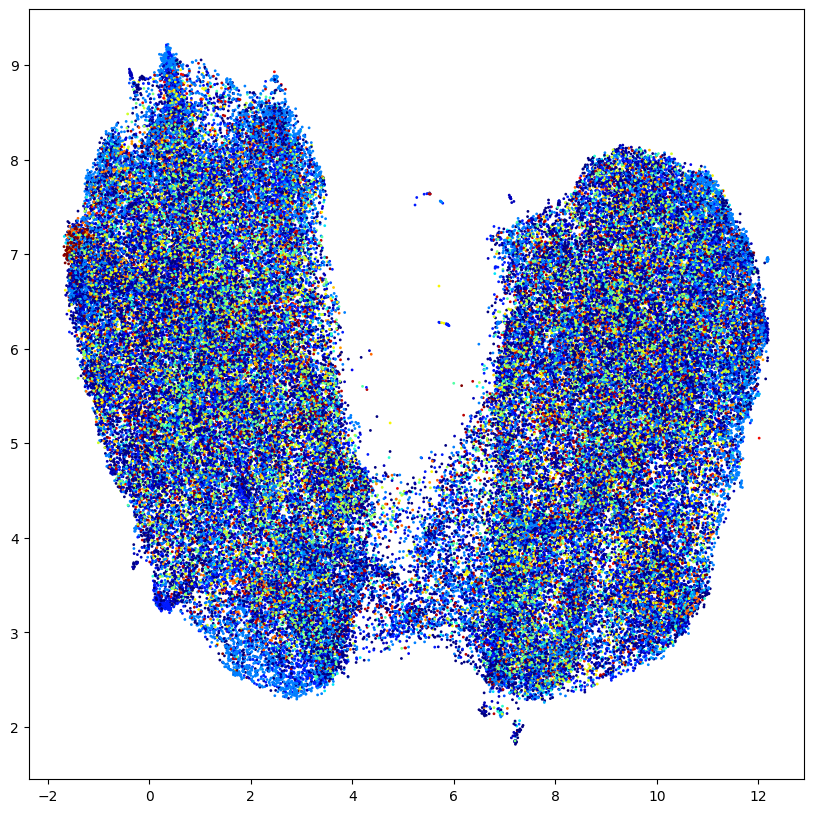

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y[:100000], s=1, cmap=plt.cm.get_cmap("jet", len(set(Y[:100000]))))
plt.show()  